## Time to get your hands dirty.  The transient Universe

### Tasks

1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import emcee
import corner
from IPython.display import display, Math

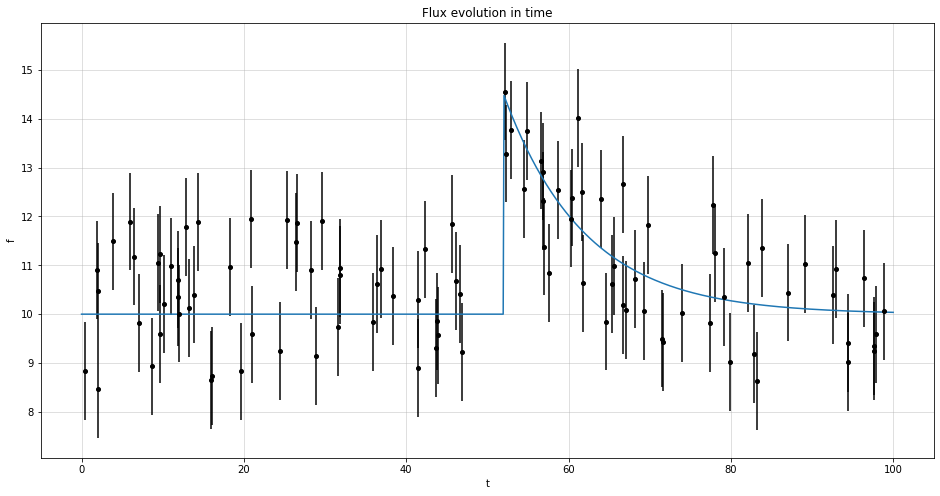

In [12]:
data_file = "/home/sara/astrostatistics/astrostatistics_bicocca_2022/solutions/transient.npy"
data = np.load(data_file)

t = data[:,0]
f = data[:,1]
err_f = data[:,2]


def burst(p, t):
    b, A, t_0, alpha = p
    if t < t_0:
        return b
    if t >= t_0:
        return b + A*np.exp(-alpha*(t - t_0))
    
fig, ax = plt.subplots(figsize=(16, 8))
plt.errorbar(t, f, err_f, fmt='o', color='black', markersize = 4, label = 'data')
plt.xlabel('t') 
plt.ylabel("f") 
plt.title('Flux evolution in time')
plt.grid(alpha = 0.5)

t_plot = np.linspace(0, 100, int(1e3))
p_0 = np.array([10, 4.5, 52, 0.1])
y = np.array([burst(p_0, i) for i in t_plot])
#ygrid =  burst(p_0,t)
plt.plot(t_plot, y, label = 'burst model with b = 10, ')
plt.show()


In [13]:
def logL(p, t, f, err_f, model = burst):
    b, A, t_0, alpha = p
    f_fit = np.array([burst(p, i) for i in t])
    return -0.5*np.sum((f-f_fit)**2/err_f**2)


3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

In [14]:
def log_prior(p):
    b, A, t_0, alpha = p
    if (0<b< 50) and (0<A<50) and (0<t_0<100) and (-5<np.log(alpha)<5):
        return 0.0
    return -np.inf

def log_post (p, t, f, err_f, model = burst):
    if not np.isfinite(log_prior(p)):
        return -np.inf
    
    return logL(p, t, f, err_f, model = burst) + log_prior(p)

In [15]:
ndim = 4
nwalkers = 24
nsteps = int(1e5)

#starting parameters
pos = p_0 + 1e-1*np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args = (t, f, err_f, burst))
sampler.run_mcmc(pos, nsteps)

/tmp/ipykernel_17994/4230926251.py:3: RuntimeWarning: invalid value encountered in log
  if (0<b< 50) and (0<A<50) and (0<t_0<100) and (-5<np.log(alpha)<5):
/home/sara/.local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


State([[10.44896268  4.78508717 48.86838709  0.12128851]
 [10.40587429  5.83486149 50.51124641  0.1453936 ]
 [10.34498828  3.75863556 51.5837594   0.09555846]
 [10.3010682   5.71956143 49.1635208   0.13156018]
 [10.60886478  3.4923382  52.09820253  0.15180308]
 [10.44487349  4.80819011 47.01285523  0.12006536]
 [10.42047821  5.32334396 48.69076892  0.11845977]
 [10.32968226  4.33496254 50.38731414  0.10818201]
 [10.19984514  7.24027933 47.54273062  0.13038499]
 [10.46017286  5.87227724 49.52214916  0.15240237]
 [10.11828067  6.92827101 49.03979392  0.15767358]
 [10.24158513  7.98663593 47.81503519  0.12738052]
 [10.26942152  4.72041398 48.69795094  0.0978122 ]
 [10.2585348   5.10388689 49.61112662  0.09750022]
 [10.24551549  7.34678566 48.28511564  0.14209586]
 [10.43846972  6.01970083 48.49008679  0.12037136]
 [10.43423217  6.81296648 47.86410267  0.15138658]
 [10.39259429  5.90518844 48.85963365  0.14941832]
 [10.43484211  8.22421598 47.27520686  0.16341447]
 [10.30232864 10.17674485

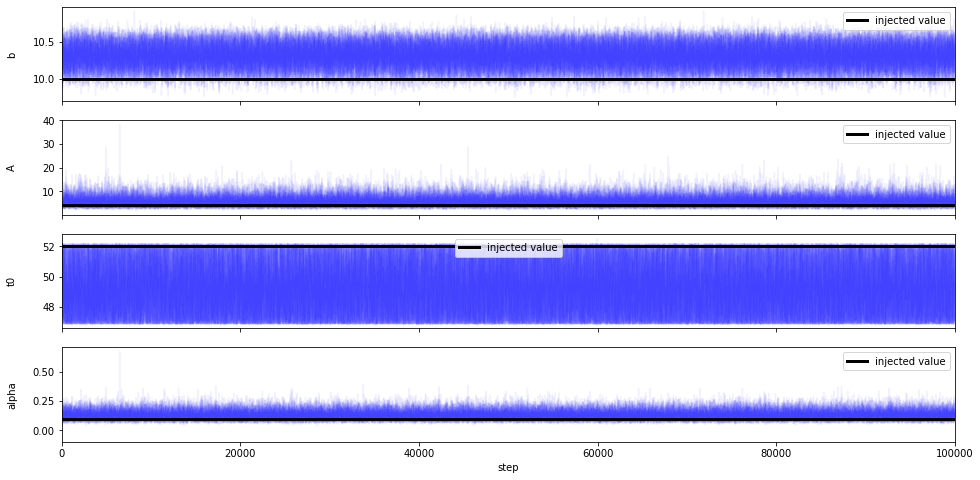

In [16]:
fig, axes = plt.subplots(4, figsize=(16, 8), sharex=True)
samples = sampler.get_chain()
pars = ["b","A","t0","alpha"]

for i in range(ndim):
    ax = axes[i]

    ax.plot(samples[:, :, i], "b", alpha=0.05)
    ax.axhline(p_0[i], linewidth=3, color='k', label = "injected value")
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(pars[i])
    ax.yaxis.set_label_coords(-0.05, 0.5)
    ax.legend()
axes[-1].set_xlabel("step");


4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

In [17]:
autocorr_length = sampler.get_autocorr_time()
print(autocorr_length)

thinned_chains = sampler.get_chain(discard=3*int(max(autocorr_length)), thin=int(max(autocorr_length)), flat=True)
print(thinned_chains.shape)

[60.54121432 82.47369479 80.53583193 68.30190087]
(29184, 4)


5) Make a corner plot of the  4 -D parameter space, with labels,  [68,95]%  credible levels and quantiles, and titles.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

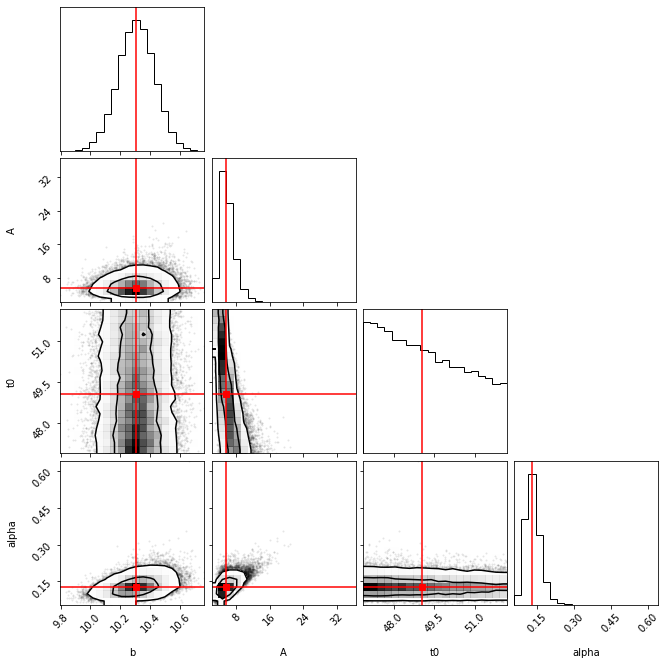

In [18]:
medians = np.zeros([ndim])
credible_region = np.zeros([ndim, 2])
#compute median and 90% credible regions
for i in range(ndim):
    mcmc = np.percentile(thinned_chains[:, i], [5, 50, 95])
    medians[i] = mcmc[1]
    q = np.diff(mcmc)
    credible_region[i] = np.array([q[0], q[1]])    
    txt = "\mathrm{{{3}}} = {0:.3f}_{{{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], pars[i])
    display(Math(txt))

fig = corner.corner(thinned_chains, labels=pars, truths=medians, truth_color='r', hist_kwargs={"density":True}, levels=[0.68,0.95]);

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

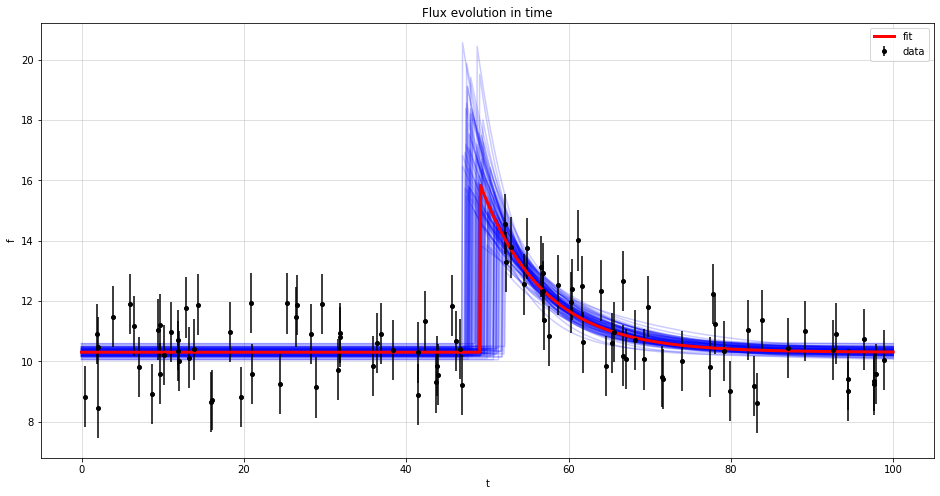

In [21]:
#select randomly 100 sets of parameters
index = np.random.choice(np.arange(0, len(thinned_chains)), size=100)
plot_pars = np.array([thinned_chains[ind] for ind in index])

fig, ax = plt.subplots(figsize=(16, 8))

for i in range(len(index)):  
    time_series = np.array([burst(plot_pars[i], time) for time in t_plot])
    plt.plot(t_plot, time_series, color = 'blue', alpha = 0.2)

best_fit = np.array([burst(medians, time) for time in t_plot])

plt.errorbar(t, f, err_f, fmt='o', color='black', markersize = 4, label = "data")
plt.plot(t_plot, best_fit, color='red', linewidth=3, label = "fit")
plt.xlabel('t')
plt.ylabel("f") 
plt.title('Flux evolution in time')
plt.legend()
plt.grid(alpha = 0.5)

## Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [22]:
import dynesty  
import scipy
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

In [53]:
#gaussian profile 

def gauss(p, t):
    b, A, t_0, sigma_W = p
    return b + A*np.exp(-(t-t_0)**2/(2*sigma_W**2))

#multivariate normal likelihood
def loglike(u, t, f, err_f, model):
    if model == burst:
        f_fit = np.array([burst(u, i) for i in t])
    
    if model == gauss:
        f_fit = np.array([gauss(u, i) for i in t])
        
    return -0.5*np.sum((f-f_fit)**2/err_f**2)


#uniform prior
def uprior(u, model):
    if model == burst:
        ub, uA, ut_0, ualpha = u
        b = ub*50
        A = uA*50
        t_0 = ut_0*100    
        alpha = scipy.stats.loguniform.ppf(ualpha,np.exp(-5),np.exp(5))
        p = np.array([b, A, t_0, alpha])
        
    if model == gauss:
        ub, uA, ut_0, usigma_W = u
        b = ub*50
        A = uA*50
        t_0 = ut_0*100    
        sigma_W = scipy.stats.loguniform.ppf(usigma_W,np.exp(-3),np.exp(3))
        
        p = np.array([b, A, t_0, sigma_W])
    return p

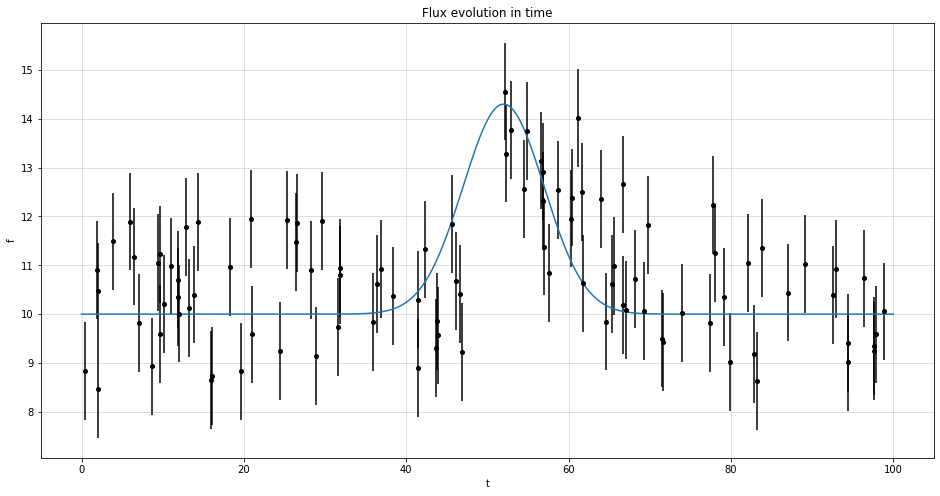

In [32]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.errorbar(t, f, err_f, fmt='o', color='black', markersize = 4)
plt.xlabel('t') 
plt.ylabel("f") 
plt.title('Flux evolution in time')
plt.grid(alpha = 0.5)

p_0 = np.array([10, 4.3, 52, 5])
y = np.array([gauss(p_0, i) for i in t_plot])
plt.plot(t_plot, y)
plt.show()


### Nested Sampling for Burst model

In [79]:
ndim = 4
model = burst
sampler = dynesty.NestedSampler(loglike, uprior, ndim, logl_args = [t, f, err_f, model], ptform_args = [model], nlive = 150)
sampler.run_nested()
results_burst = sampler.results

2405it [00:07, 337.58it/s, +150 | bound: 36 | nc: 1 | ncall: 13759 | eff(%): 18.570 | loglstar:   -inf < -48.754 <    inf | logz: -62.842 +/-  0.413 | dlogz:  0.001 >  0.159]


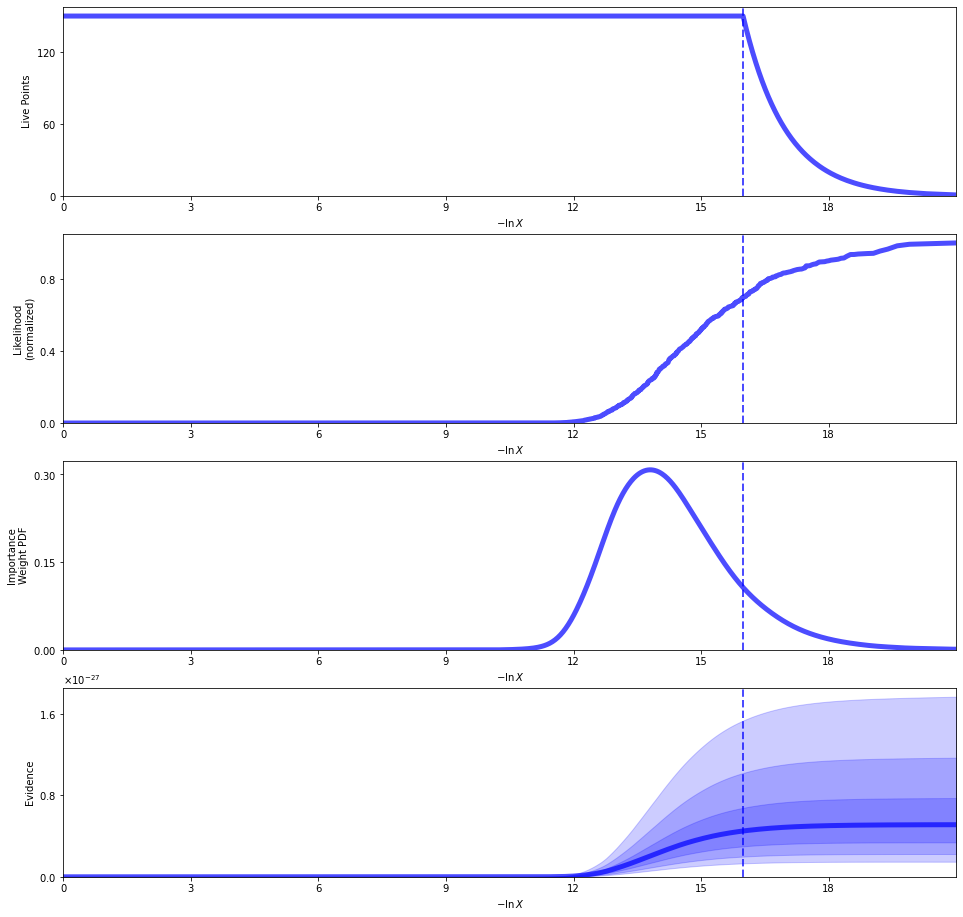

In [80]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results_burst)

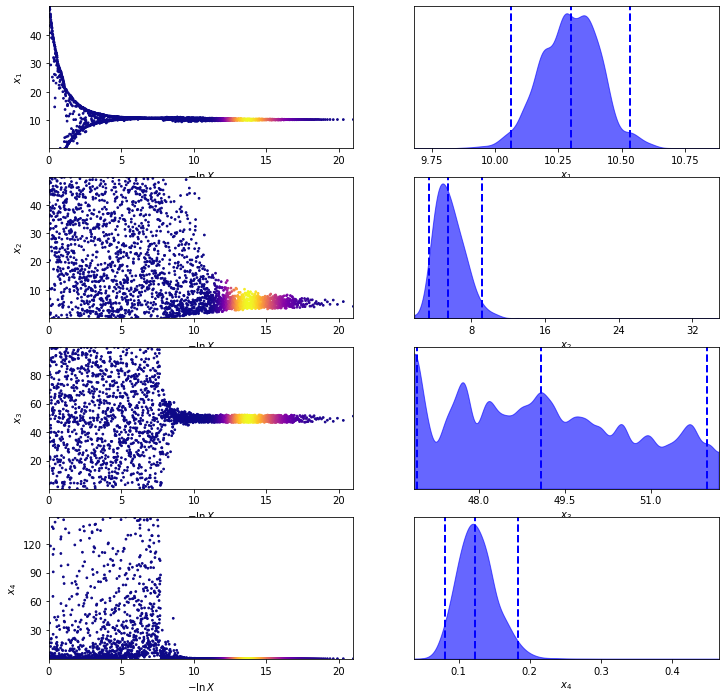

In [81]:
tfig, taxes = dyplot.traceplot(results_burst)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

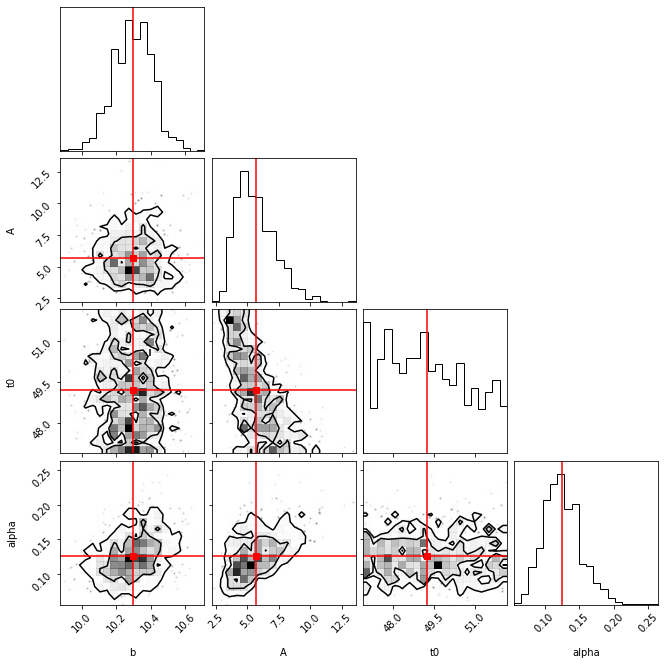

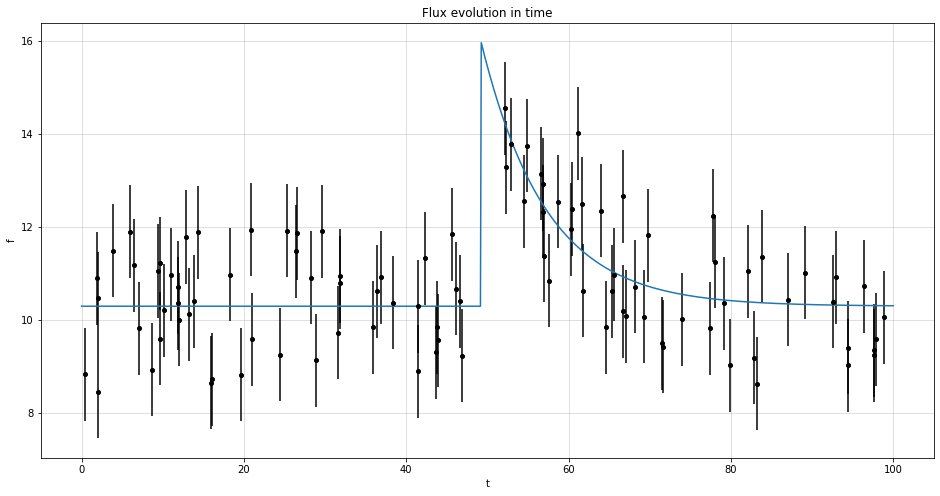

In [82]:
samples_burst = results_burst.samples
w_burst = np.exp(results_burst.logwt - results_burst.logz[-1])

evidence_burst = results_burst.logz[-1]

quantiles_burst = [dyfunc.quantile(s, [0.16, 0.84], weights=w_burst)
             for s in samples_burst.T]

mean_burst, cov_burst = dyfunc.mean_and_cov(samples_burst, w_burst)

# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(results_burst)

#weighted samples resampling
samples_equal_burst = dyfunc.resample_equal(samples_burst, w_burst)

pars = ["b","A","t0","alpha"]
for i in range(ndim):  
    txt = "\mathrm{{{3}}} = {0:.3f}_{{{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mean_burst[i], quantiles_burst[i][0], quantiles_burst[i][1], pars[i])
    display(Math(txt))

corner.corner(samples_equal_burst, labels=pars, truths=mean_burst, truth_color='r', hist_kwargs={"density":True}, levels=[0.68,0.95])


fig, ax = plt.subplots(figsize=(16, 8))
plt.errorbar(t, f, err_f, fmt='o', color='black', markersize = 4)
plt.xlabel('t') 
plt.ylabel("f") 
plt.title('Flux evolution in time')
plt.grid(alpha = 0.5)

y = np.array([model(mean_burst, i) for i in t_plot])
plt.plot(t_plot, y)
plt.show()

### Nested Sampling for Gaussian Model

In [83]:
ndim = 4
model = gauss
sampler = dynesty.NestedSampler(loglike, uprior, ndim, logl_args = [t, f, err_f, model], ptform_args = [model])
sampler.run_nested()
results_gauss = sampler.results

8202it [00:31, 261.12it/s, +500 | bound: 36 | nc: 1 | ncall: 44277 | eff(%): 19.654 | loglstar:   -inf < -52.446 <    inf | logz: -68.121 +/-  0.250 | dlogz:  0.001 >  0.509]


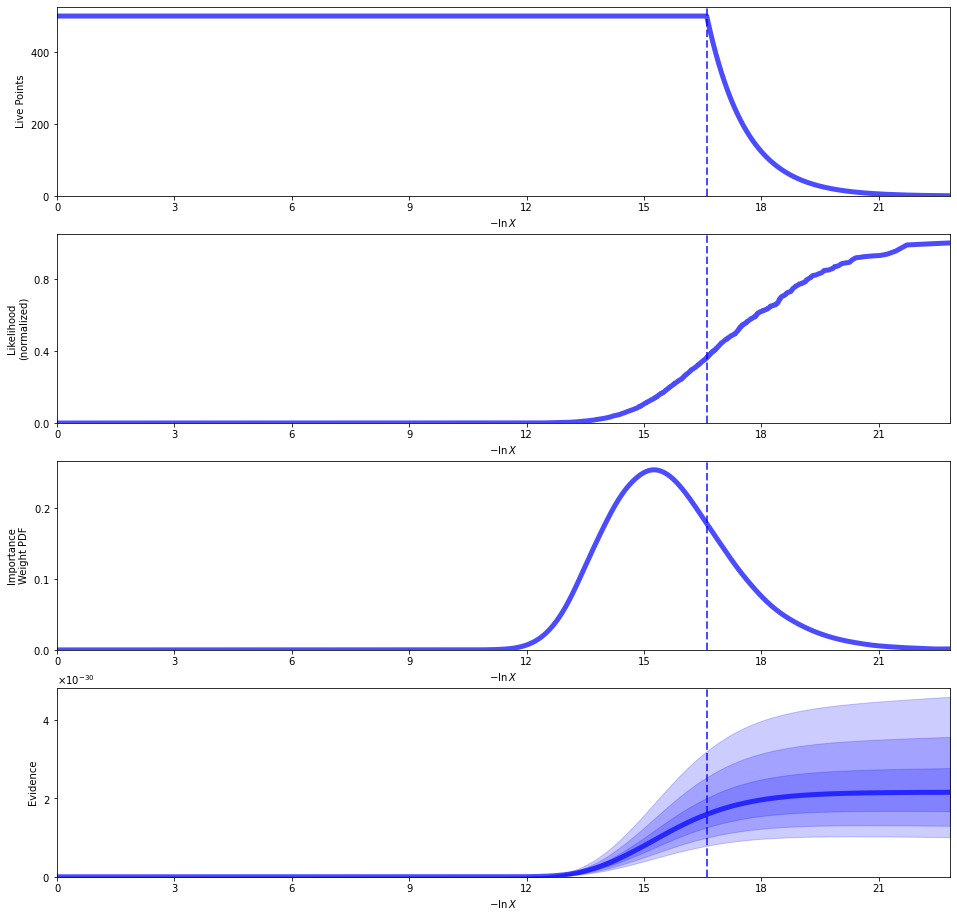

In [74]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results_gauss)

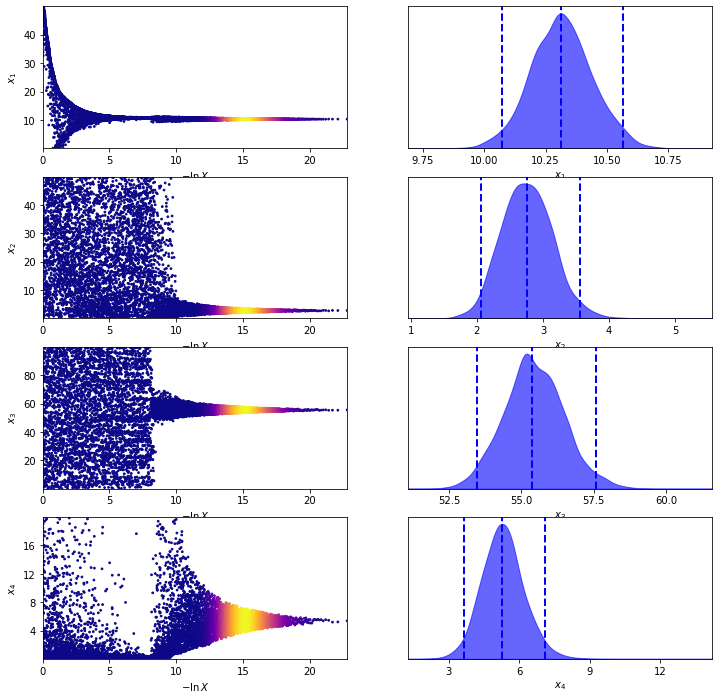

In [75]:
tfig, taxes = dyplot.traceplot(results_gauss)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

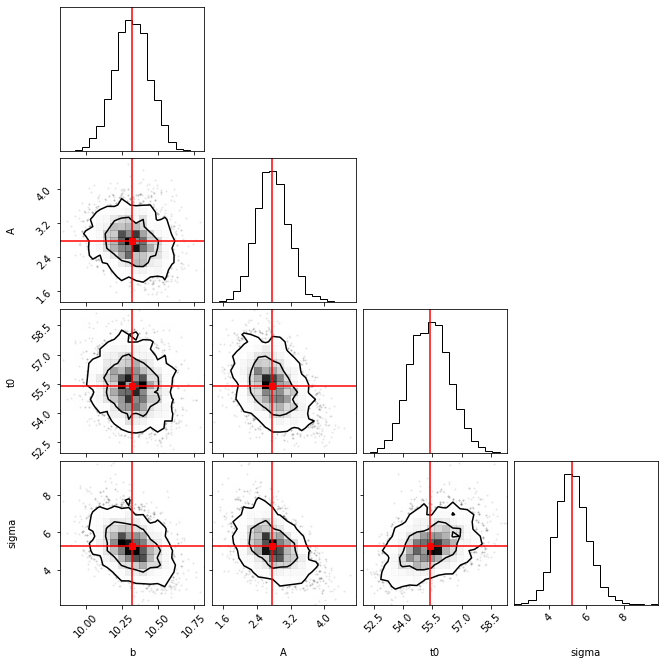

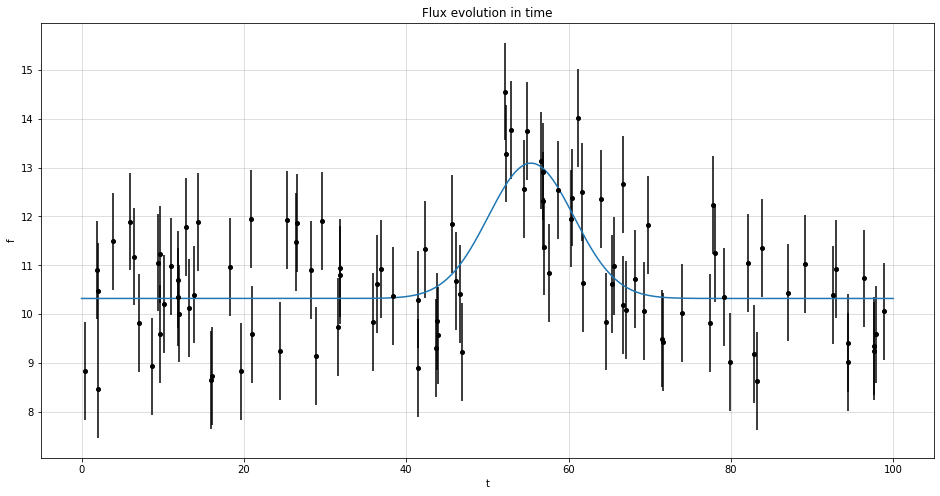

In [84]:
samples_gauss = results_gauss.samples
w_gauss  = np.exp(results_gauss .logwt - results_gauss .logz[-1])

evidence_gauss = results_gauss .logz[-1]

quantiles_gauss  = [dyfunc.quantile(s, [0.16, 0.84], weights=w_gauss )
             for s in samples_gauss .T]

mean_gauss , cov_gauss  = dyfunc.mean_and_cov(samples_gauss , w_gauss )

# Generate a new set of results with statistical+sampling uncertainties.
results_sim_gauss  = dyfunc.simulate_run(results_gauss)

#weighted samples resampling
samples_equal_gauss = dyfunc.resample_equal(samples_gauss, w_gauss)

pars = ["b","A","t0","sigma"]
for i in range(ndim):  
    txt = "\mathrm{{{3}}} = {0:.3f}_{{{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mean[i], quantiles[i][0], quantiles[i][1], pars[i])
    display(Math(txt))

    
corner.corner(samples_equal_gauss, labels=pars, truths=mean_gauss, truth_color='r', hist_kwargs={"density":True}, levels=[0.68,0.95])


fig, ax = plt.subplots(figsize=(16, 8))
plt.errorbar(t, f, err_f, fmt='o', color='black', markersize = 4)
plt.xlabel('t') 
plt.ylabel("f") 
plt.title('Flux evolution in time')
plt.grid(alpha = 0.5)

y = np.array([model(mean_gauss, i) for i in t_plot])
plt.plot(t_plot, y)
plt.show()


In [85]:
B = np.exp(evidence_burst - evidence_gauss)
print("log(Evidence) burst model = ", evidence_burst)
print("log(Evidence) gauss model = ", evidence_gauss)
print("Evidence ratio between burst and gaussian model = ", B)

log(Evidence) burst model =  -62.84232763821749
log(Evidence) gauss model =  -68.12060404337409
Evidence ratio between burst and gaussian model =  196.0317047655007
